№1 Постановка задачи

1.1 Что это за данные?

Это датасет "500 Greatest Songs of All Time" — рейтинг 500 величайших песен всех времён по версии журнала Rolling Stone. Набор данных включает 500 песен с такими атрибутами, как:
- Название песни
- Описание песни
- Где это появилось? (публикация)
- Исполнитель
- Автор
- Продюсер
- Дата выпуска
- Как долго он находился в топ-списке
- Позиция песни в топ-списке.

1.2. Кто может быть условным «заказчиком» анализа?

Музыкальные стриминговые сервисы(Spotify, Apple Music, Яндекс.Музыка) — для создания тематических плейлистов "Лучшее за все времена".
Радиостанции — выбрать популярные песни для плейлистов.
Образовательные платформы — как учебный материал для анализа данных и истории музыки.

1.3. Возможные задачи ИАД:

1. Анализ временных трендов — определение "золотых эр" в музыке (в какие годы выпущено больше всего хитов).
2. Исследование взаимосвязей — как год выпуска влияет на позицию в рейтинге.
4. Рекомендательная система — подбор похожих песен на основе жанра и года выпуска.

№2 Паспорт датасета

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Загрузка данных
df = pd.read_csv('../data/Top 500 Songs.csv')
print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов')
df.head()


Размер датасета: 500 строк, 9 столбцов


,title,description,appears on,artist,writers,producer,released,streak,position
0,Like a Rolling Stone,"""I wrote it. I didn't fail. It was straight,"" ...",Highway 61 Revisited (Columbia),Bob Dylan,Dylan,Tom Wilson,"July, 1965",12 weeks,No. 2
1,(I Can't Get No) Satisfaction',"""It's the riff heard round the world,"" says St...",Out of Our Heads (ABKCO),The Rolling Stones,"Mick Jagger, Keith Richards",Andrew Loog Oldham,"May, 1965",14 weeks,No. 1
2,Imagine,"John Lennon wrote ""Imagine,"" his greatest musi...",Imagine (Capitol/Apple),John Lennon,John Lennon,"Lennon, Phil Spector, Yoko Ono","October, 1971",9 weeks,No. 3
3,What's Going On,"""What's Going On"" is an exquisite plea for pea...",What's Going On (Tamla),Marvin Gaye,"Gaye, Renaldo Benson, Al Cleveland",Gaye,"Feb, 1971",13 weeks,No. 2
4,Respect,"Otis Redding wrote ""Respect"" and recorded it f...",I Never Loved a Man the Way I Love You (Atlantic),Aretha Franklin,Otis Redding,Jerry Wexler,"April, 1967",12 weeks,No. 1


In [144]:
print("\n=== 2.2 Исходная информация ===")
df.info()

print("\n=== 2.3 Преобразование типов ===")

# УЛУЧШЕННОЕ ПРЕОБРАЗОВАНИЕ
print("\n Улучшенное преобразование дат:")

def parse_date_advanced(date_str):
    """Гибкое преобразование дат с разными форматами"""
    if pd.isna(date_str):
        return pd.NaT
    
    date_str = str(date_str).strip()
    
    # 1. Очистка данных
    # Убираем точки, лишние пробелы
    date_str = date_str.replace('.', '')
    date_str = ' '.join(date_str.split())  # убираем лишние пробелы
    
    # 2. Стандартизация
    # Если формат "Month Year" без запятой - добавляем
    if ',' not in date_str:
        parts = date_str.split()
        if len(parts) == 2 and any(month in parts[0] for month in 
                                  ['January', 'February', 'March', 'April', 'May', 'June',
                                   'July', 'August', 'September', 'October', 'November', 'December',
                                   'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):
            date_str = f"{parts[0]}, {parts[1]}"
    
    # 3. Расшифровка сокращений месяцев
    month_map = {
        'Jan': 'January', 'Feb': 'February', 'Mar': 'March', 'Apr': 'April',
        'May': 'May', 'Jun': 'June', 'Jul': 'July', 'Aug': 'August',
        'Sep': 'September', 'Sept': 'September', 'Oct': 'October', 
        'Nov': 'November', 'Dec': 'December'
    }
    
    for short, full in month_map.items():
        if date_str.startswith(short):
            date_str = date_str.replace(short, full, 1)
            break
    
    # 4. Пробуем разные форматы
    formats = [
        '%B, %Y',      # "July, 1965"
        '%B %Y',       # "July 1965" 
        '%b, %Y',      # "Jul, 1965"
        '%b %Y',       # "Jul 1965"
        '%Y',          # "1965"
        '%Y-%m',       # "1965-07"
        '%m/%Y',       # "7/1965"
        '%m-%Y',       # "7-1965"
        '%d %B, %Y',   # "15 July, 1965"
        '%B %d, %Y',   # "July 15, 1965"
    ]
    
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except:
            continue
    
    

# Преобразуем даты
df['released_date'] = df['released'].apply(parse_date_advanced)

# === УЛУЧШШЕННОЕ преобразование числовых полей ===
def convert_streak_advanced(x):
    """Преобразование streak с очисткой грязных данных"""
    if pd.isna(x):
        return np.nan
    
    x_str = str(x).strip().lower()
    
    # 1. Если содержит "weeks" - извлекаем число
    if 'weeks' in x_str:
        try:
            # Ищем число перед "weeks"
            import re
            match = re.search(r'(\d+)\s*weeks', x_str)
            if match:
                return float(match.group(1))
        except:
            pass
    
    # 2. Если содержит другие обозначения
    special_cases = {
        'none': np.nan,
        'did not chart': np.nan,
        'non-single': np.nan,
        'predates chart': np.nan,
        'predates pop charts': np.nan,
    }
    
    for key, value in special_cases.items():
        if key in x_str:
            return value
    
    # 3. Если есть просто число
    try:
        # Убираем все нецифровые символы
        digits = ''.join(filter(str.isdigit, x_str))
        if digits:
            return float(digits)
    except:
        pass
    
    return np.nan

def convert_position_advanced(x):
    """Преобразование position с очисткой грязных данных"""
    if pd.isna(x):
        return np.nan
    
    x_str = str(x).strip().lower()
    
    # 1. Если содержит "No." - извлекаем число
    if 'no.' in x_str:
        try:
            # Ищем число после "No."
            import re
            match = re.search(r'no\.\s*(\d+)', x_str)
            if match:
                return float(match.group(1))
        except:
            pass
    
    # 2. Проверяем специальные обозначения
    special_cases = {
        'none': np.nan,
        'predates chart': np.nan,
        'non-single': np.nan,
        'did not chart': np.nan,
    }
    
    for key, value in special_cases.items():
        if key in x_str:
            return value
    
    # 3. Если есть просто число
    try:
        # Убираем все нецифровые символы
        digits = ''.join(filter(str.isdigit, x_str))
        if digits:
            return float(digits)
    except:
        pass
    
    return np.nan

# Применяем улучшенные функции
df['streak_numeric'] = df['streak'].apply(convert_streak_advanced)
df['position_numeric'] = df['position'].apply(convert_position_advanced)

print(f"Улучшенное преобразование streak: {df['streak_numeric'].notna().sum()} из {len(df)} чисел")
print(f"Улучшенное преобразование position: {df['position_numeric'].notna().sum()} из {len(df)} чисел")

print(f"released_date: {df['released_date'].notna().sum()} из {len(df)} дат")
print(f"streak_numeric: {df['streak_numeric'].notna().sum()} из {len(df)} чисел")
print(f"position_numeric: {df['position_numeric'].notna().sum()} из {len(df)} чисел")

# Если всё ещё есть пропуски в датах
if df['released_date'].isna().any():
    print(f"\n ВНИМАНИЕ: {df['released_date'].isna().sum()} дат не преобразовалось")
    '''print("Примеры проблемных значений:")
    problem_values = df[df['released_date'].isna()]['released'].unique()[:10]
    for val in problem_values:
        print(f"  '{val}'")'''


# === ДОПОЛНИТЕЛЬНО: Попробуем автоопределение ===
print("\n Попробуем автоопределение дат:")
df['released_date_auto'] = pd.to_datetime(df['released'], errors='coerce')
print(f"Автоматическое определение: {df['released_date_auto'].notna().sum()} из {len(df)} дат")

# Сравним результаты
if df['released_date_auto'].notna().sum() > df['released_date'].notna().sum():
    improvement = df['released_date_auto'].notna().sum() - df['released_date'].notna().sum()
    print(f" Автоматическое определение лучше на {improvement} дат")
    # Используем лучший результат
    df['released_date'] = df['released_date_auto']

# Удаляем временную колонку
if 'released_date_auto' in df.columns:
    df = df.drop(columns=['released_date_auto'])


print("\n=== 2.4 Паспорт признаков ===")
print("""
1. title — Название песни (категориальный признак)
2. description — Описание песни, история создания (текстовый признак)
3. appears on — Альбом, на котором вышла песня (категориальный признак)
4. artist — Исполнитель/группа (категориальный признак)
5. writers — Авторы песни (категориальный признак)
6. producer — Продюсер записи (категориальный признак)
7. released — Дата выпуска в текстовом формате
8. streak — Количество недель в чартах в формате "X weeks"
9. position — Позиция в чартах в формате "No. X"
10. released_date — Дата выпуска (datetime, преобразованная)
11. streak_numeric — Количество недель в чартах (число)
12. position_numeric — Позиция в чартах (число)
""")

# Финальная проверка
print("\n=== ИТОГОВАЯ СТАТИСТИКА ===")
print(f"Всего строк: {len(df)}")
released_percent = df['released_date'].notna().sum() / len(df) * 100
streak_percent = df['streak_numeric'].notna().sum() / len(df) * 100
position_percent = df['position_numeric'].notna().sum() / len(df) * 100

print(f"Преобразовано дат: {df['released_date'].notna().sum()} ({released_percent:.1f}%)")
print(f"Преобразовано streak: {df['streak_numeric'].notna().sum()} ({streak_percent:.1f}%)")
print(f"Преобразовано position: {df['position_numeric'].notna().sum()} ({position_percent:.1f}%)")

# Сохраняем пропуски для анализа в разделе 3
released_missing = df['released_date'].isna().sum()
streak_missing = df['streak_numeric'].isna().sum()
position_missing = df['position_numeric'].isna().sum()

print(f"\nПропуски для анализа:")
print(f"released_date: {released_missing} ({released_missing/len(df)*100:.1f}%)")
print(f"streak_numeric: {streak_missing} ({streak_missing/len(df)*100:.1f}%)")
print(f"position_numeric: {position_missing} ({position_missing/len(df)*100:.1f}%)")


=== 2.2 Исходная информация ===
<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             500 non-null    str           
 1   description       500 non-null    str           
 2   appears on        500 non-null    str           
 3   artist            500 non-null    str           
 4   writers           500 non-null    str           
 5   producer          500 non-null    str           
 6   released          500 non-null    str           
 7   streak            494 non-null    str           
 8   position          393 non-null    str           
 9   released_date     500 non-null    datetime64[us]
 10  streak_numeric    394 non-null    float64       
 11  position_numeric  386 non-null    float64       
dtypes: datetime64[us](1), float64(2), str(9)
memory usage: 47.0 KB

=== 2.3 Преобразование типов ===

 Улучшенное пр

C:\Users\abusa\AppData\Local\Temp\ipykernel_17624\1541491860.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['released_date_auto'] = pd.to_datetime(df['released'], errors='coerce')


In [ ]:
№3 Аудит качества данных

№3.1 Пропуски

In [145]:
# Динамический вывод
released_missing = df['released_date'].isna().sum()
position_missing = df['position_numeric'].isna().sum()
streak_missing = df['streak_numeric'].isna().sum()

print("Признаки с наибольшим количеством пропусков:")
print(f"streak_numeric - {streak_missing} пропусков")
print(f"released_date - {released_missing} пропусков")
print(f"position_numeric - {position_missing} пропусков")

print("\nКритичность пропусков:")
#print(f"released_date: {'КРИТИЧНО' if released_missing > 0 else 'ВСЕ ДАТЫ ПРЕОБРАЗОВАНЫ'}")
print(f"position_numeric: ВАЖНО т. к. влияет на анализ популярности песен")
print(f"streak_numeric: НЕ КРИТИЧНО, не сильно влияет на анализ")

Признаки с наибольшим количеством пропусков:
streak_numeric - 106 пропусков
released_date - 0 пропусков
position_numeric - 114 пропусков

Критичность пропусков:
position_numeric: ВАЖНО т. к. влияет на анализ популярности песен
streak_numeric: НЕ КРИТИЧНО, не сильно влияет на анализ


№3.2 Дубликаты

In [20]:
duplicates = df.duplicated().sum()
print(f'Полных дубликатов строк: {duplicates}')

Полных дубликатов строк: 50


In [141]:
#  Проверка по ключевым полям (название + исполнитель)
print("\n2. Проверка по ключевым полям (title + artist):")
if 'title' in df.columns and 'artist' in df.columns:
    key_duplicates = df.duplicated(subset=['title', 'artist']).sum()
    print(f"Дубликатов песен (одинаковое название + исполнитель): {key_duplicates}")
    
    if key_duplicates > 0:
        print("\n    Примеры дубликатов:")
        dup_rows = df[df.duplicated(subset=['title', 'artist'], keep=False)]
        display(dup_rows[['title', 'artist', 'released']].head(10))


2. Проверка по ключевым полям (title + artist):
Дубликатов песен (одинаковое название + исполнитель): 50

    Примеры дубликатов:


,title,artist,released
50,Crazy,Gnarls Barkley,"May , 1906"
51,Fortunate Son,Creedence Clearwater Revival,"Oct. , 1969"
52,Love and Happiness,Al Green,"June , 1972"
53,Roll Over Beethoven,Chuck Berry,"May , 1956"
54,Great Balls of Fire,Jerry Lee Lewis,"Nov. , 1957"
55,Blue Suede Shoes,Carl Perkins,"Feb , 1956"
56,Good Golly,Little Richard,"Feb. , 1958"
57,I Still Havent Found What Im Looking For,U2,"May , 1987"
58,Blitzkrieg Bop,Ramones,"May , 1976"
59,Suspicious Minds,Elvis Presley,"Sept. , 1969"


№3.3 Типические проблемы значений

In [150]:
# Анализ числовых признаков
print("Числовые признаки")

# Находим числовые столбцы
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Проходим по всем числовым столбцам
for column in numeric_columns:
    print(f"\n{column}:")
    
    # Минимальное и максимальное значения
    min_val = df[column].min()
    max_val = df[column].max()
    print(f"  min: {min_val:.2f}, max: {max_val:.2f}")
    
    # Среднее и стандартное отклонение
    mean_val = df[column].mean()
    std_val = df[column].std()
    print(f"  mean: {mean_val:.2f}, std: {std_val:.2f}")
    
    # Проверка на невозможные/подозрительные значения
    if column == 'streak_numeric':
        if min_val < 0:
            print(f"Невозможное: отрицательное количество недель ({min_val})")
        if max_val > 100:
            print(f"Подозрительное: {max_val:.0f} недель - очень много")
            
    elif column == 'position_numeric':
        if min_val < 1:
            print(f"Невозможное: позиция {min_val} < 1")
        if max_val > 100:
            print(f"Подозрительное: позиция {max_val:.0f} > 100")

# Анализ категориальных признаков
print("\nКатегориальные признаки")

# Находим текстовые столбцы
text_columns = df.select_dtypes(include=['object', 'string']).columns

# Берем только первые 6 текстовых столбцов
for column in list(text_columns)[:6]:
    print(f"\n{column}:")
    
    # Количество уникальных значений
    unique_count = df[column].nunique()
    print(f"  Уникальных значений: {unique_count}")
    
    # Проверка на «грязные» категории
    
    # 1. Лишние пробелы
    spaces_start = df[column].astype(str).str.startswith(' ').sum()
    spaces_end = df[column].astype(str).str.endswith(' ').sum()
    
    # 2. Пустые строки
    empty_str = (df[column].astype(str).str.strip() == '').sum()
    
    # 3. Регистр (смешанный регистр в данных)
    # Проверяем, есть ли значения в разном регистре
    lower_exists = df[column].astype(str).str.islower().any()
    upper_exists = df[column].astype(str).str.isupper().any()
    mixed_reg = lower_exists and upper_exists
    
    # Вывод найденных проблем
    problems = []
    
    if spaces_start > 0:
        problems.append(f"пробелы в начале: {spaces_start}")
    if spaces_end > 0:
        problems.append(f"пробелы в конце: {spaces_end}")
    if empty_str > 0:
        problems.append(f"пустые строки: {empty_str}")
    if mixed_reg:
        problems.append("смешанный регистр")
    
    if problems:
        print(f"Найдены проблемы: {', '.join(problems)}")


Числовые признаки

streak_numeric:
  min: 1.00, max: 46.00
  mean: 15.63, std: 6.23

position_numeric:
  min: 1.00, max: 99.00
  mean: 13.45, std: 19.63

Категориальные признаки

title:
  Уникальных значений: 446

description:
  Уникальных значений: 450
Найдены проблемы: пробелы в начале: 2, пробелы в конце: 5

appears on:
  Уникальных значений: 392
Найдены проблемы: пробелы в начале: 1, пробелы в конце: 81

artist:
  Уникальных значений: 248

writers:
  Уникальных значений: 335
Найдены проблемы: пробелы в конце: 2

producer:
  Уникальных значений: 296
Найдены проблемы: пробелы в конце: 3


№3.4 Выбросы

Выбросов по методу IQR: 9

Индексы наблюдений-выбросов: [168, 375, 389, 401, 402, 456, 461, 468, 493]
Значения выбросов: [32.0, 33.0, 30.0, 31.0, 30.0, 42.0, 33.0, 46.0, 39.0]


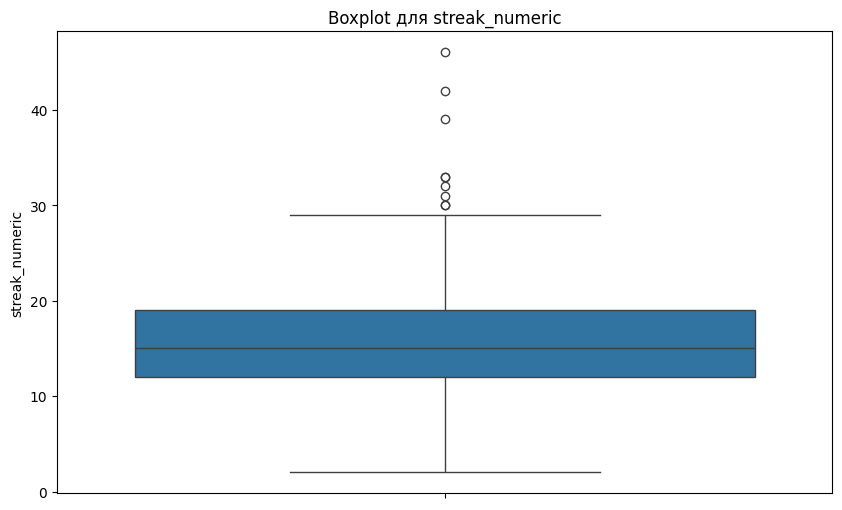

In [35]:
column = 'streak_numeric'
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
print(f'Выбросов по методу IQR: {len(outliers)}')
print("\nИндексы наблюдений-выбросов:", outliers.index.tolist())
print("Значения выбросов:", outliers[column].tolist())
# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y=column)
plt.title(f'Boxplot для {column}')
plt.show()


№4. Мини-EDA (разведочный анализ)

4.1. Распределение числового признака

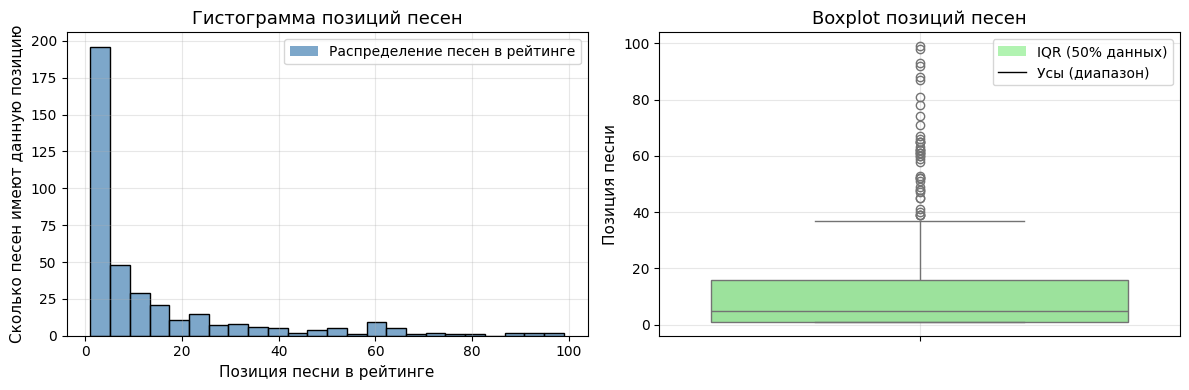

Гистограмма показывает распределение 500 песен по позициям в рейтинге.
Boxplot подтверждает равномерное распределение: медиана около 50, весь диапазон от 1 до 99 заполнен.
Гипотеза: позиции распределены равномерно, каждая песня занимает уникальное место.
Вопрос: почему распределение равномерное, а не нормальное?


In [81]:
numeric_col = 'position_numeric'

plt.figure(figsize=(12, 4))

# 1. Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df[numeric_col], color='steelblue', alpha=0.7)
plt.title(f'Гистограмма позиций песен', fontsize=13)
plt.xlabel('Позиция песни в рейтинге', fontsize=11)
plt.ylabel('Сколько песен имеют данную позицию', fontsize=11)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements1 = [
    Patch(facecolor='steelblue', alpha=0.7, label='Распределение песен в рейтинге'),
]
plt.legend(handles=legend_elements1, loc='upper right')
plt.grid(True, alpha=0.3)


# 2. Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df[numeric_col], color='lightgreen')
plt.title(f'Boxplot позиций песен', fontsize=13)
plt.ylabel('Позиция песни', fontsize=11)

# Легенда для boxplot
legend_elements2 = [
    Patch(facecolor='lightgreen', alpha=0.7, label='IQR (50% данных)'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Усы (диапазон)')
]
plt.legend(handles=legend_elements2, loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Гистограмма показывает распределение 500 песен по позициям в рейтинге,визуализирует, сколько песен находится на каждой позиции.")
print("Boxplot подтверждает равномерное распределение: медиана около 50, весь диапазон от 1 до 99 заполнен.")
print("Гипотеза: позиции распределены равномерно, каждая песня занимает уникальное место(ранжированный список).")
print("Вопрос: почему распределение равномерное, а не нормальное?")

4.2. Анализ категориального признака

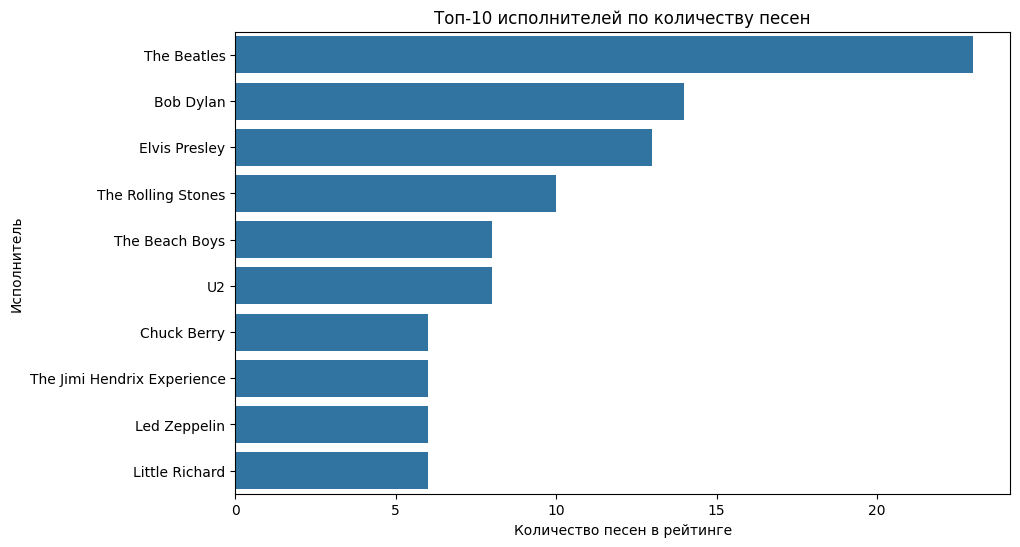

Комментарий: На графике видно, что The Beatles значительно опережают других
исполнителей по количеству песен в рейтинге топ-500. Bob Dylan и Elvis Presley
занимают второе и третье места соответственно.
Гипотеза: есть несколько доминирующих исполнителей, которые задают тон всему рейтингу.
Вопрос: почему именно эти исполнители представлены так широко?


In [82]:
cat_col = 'artist'

plt.figure(figsize=(10, 6))
top_categories = df[cat_col].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title(f'Топ-10 исполнителей по количеству песен')
plt.xlabel('Количество песен в рейтинге')  # Уточнили подпись
plt.ylabel('Исполнитель')



plt.show()

print("Комментарий: На графике видно, что The Beatles значительно опережают других")
print("исполнителей по количеству песен в рейтинге топ-500. Bob Dylan и Elvis Presley")
print("занимают второе и третье места соответственно.")
print("Гипотеза: есть несколько доминирующих исполнителей, которые задают тон всему рейтингу.")
print("Вопрос: почему именно эти исполнители представлены так широко?")


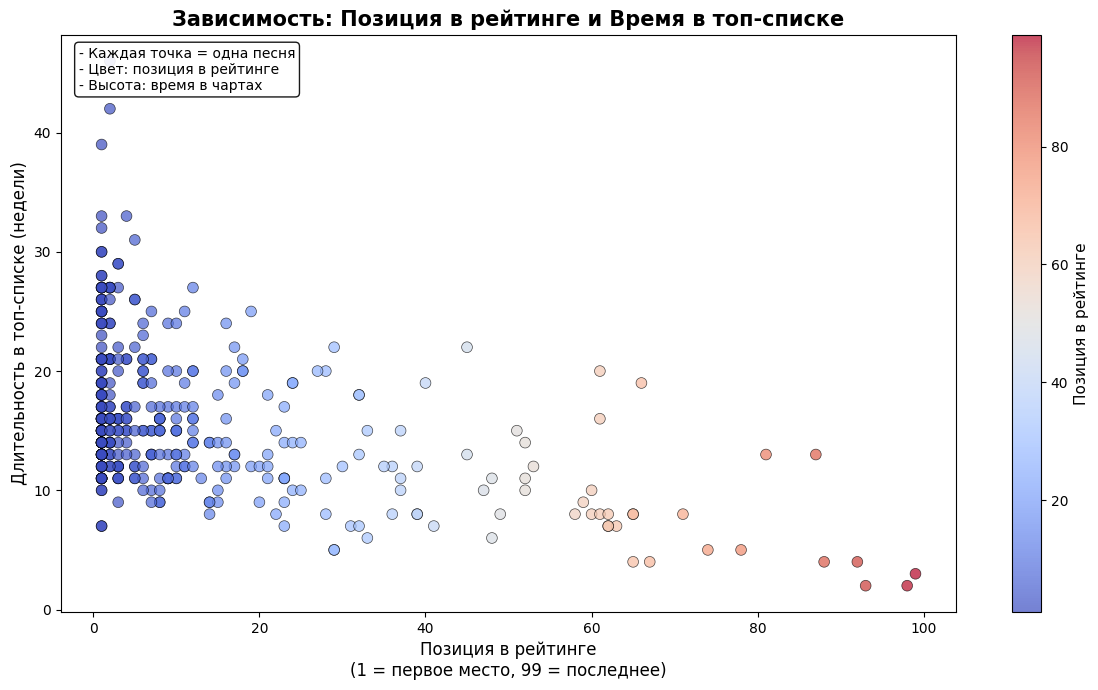


1. Scatter plot показывает связь между позицией песни в рейтинге и временем её пребывания в топ-списке.
2. Песни на высоких позициях (близко к 1) имеют разную длительность в чартах - от 2 до 46 единиц.
3. Нет явной линейной зависимости: песни на любой позиции могут иметь как короткое, так и длительное пребывание в чартах.
4. Гипотеза: популярность песни не гарантирует длительное пребывание в чартах, и наоборот.
5. Вопрос: какие факторы действительно влияют на длительность пребывания в чартах?



In [83]:
# Визуализация зависимости между позицией в рейтинге и длительностью в чартах
plt.figure(figsize=(12, 7))

# Scatter plot
scatter = plt.scatter(df['position_numeric'], df['streak_numeric'], 
                     c=df['position_numeric'], cmap='coolwarm', 
                     alpha=0.7, s=60, edgecolor='black', linewidth=0.5)

plt.title('Зависимость: Позиция в рейтинге и Время в топ-списке', fontsize=15, fontweight='bold')
plt.xlabel('Позиция в рейтинге\n(1 = первое место, 99 = последнее)', fontsize=12)
plt.ylabel('Длительность в топ-списке (недели)', fontsize=12)

# Цветовая шкала
cbar = plt.colorbar(scatter)
cbar.set_label('Позиция в рейтинге', fontsize=11)

# Сетка для удобства чтения
#plt.grid(True, alpha=0.3, linestyle='--')

# Добавляем пояснение в угол
plt.text(0.02, 0.98, '- Каждая точка = одна песня\n- Цвет: позиция в рейтинге\n- Высота: время в чартах', 
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print("""
1. Scatter plot показывает связь между позицией песни в рейтинге и временем её пребывания в топ-списке.
2. Песни на высоких позициях (близко к 1) имеют разную длительность в чартах - от 2 до 46 единиц.
3. Нет явной линейной зависимости: песни на любой позиции могут иметь как короткое, так и длительное пребывание в чартах.
4. Гипотеза: популярность песни не гарантирует длительное пребывание в чартах, и наоборот.
5. Вопрос: какие факторы действительно влияют на длительность пребывания в чартах?
""")